In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [2]:
workingDirectory = '/home/h1bennet/strains_rna/results/S02_Strains_AMLNtoControl_Stellate_RNA/'
amlnDirectory = '/home/h1bennet/strains/data/RNA/AMLN_30week_stellate/'
controlDirectory = '/home/h1bennet/strains/data/RNA/control_stellate/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Run Oyoung's pipeline to process RNA-seq data consistantly.

In [3]:
c57_control_paths = list(np.sort(glob.glob(controlDirectory+'/C57*')))
balbc_control_paths = list(np.sort(glob.glob(controlDirectory+'/BALBC*')))
aj_control_paths = list(np.sort(glob.glob(controlDirectory+'/AJ*')))

c57_control_ids = [i.split('/')[-1].split('_')[4] for i in c57_control_paths]
balbc_control_ids = [i.split('/')[-1].split('_')[4] for i in balbc_control_paths]
aj_control_ids = [i.split('/')[-1].split('_')[4] for i in aj_control_paths]

In [4]:
c57_amln_paths = list(np.sort(glob.glob(amlnDirectory+'/NCoRWT*')))
balbc_amln_paths = list(np.sort(glob.glob(amlnDirectory+'/balb*')))
aj_amln_paths = list(np.sort(glob.glob(amlnDirectory+'/aj*')))

c57_amln_ids = [i.split('/')[-1].split('_')[5] for i in c57_amln_paths]
balbc_amln_ids = [i.split('/')[-1].split('_')[5] for i in balbc_amln_paths]
aj_amln_ids = [i.split('/')[-1].split('_')[5] for i in aj_amln_paths]

Put together into three separate comparisons

In [7]:
ids = ['c57_stellate_control_young',
       'c57_stellate_amlndiet_30weeks',
       'balbc_stellate_control_young',
       'balbc_stellate_amlndiet_30weeks',
       'aj_stellate_control_young',
       'aj_stellate_amlndiet_30weeks']

colors = ['#74c476',
          '#006d2c',
          '#6baed6',
          '#08519c',
          '#de2d26',
          '#a50f15']

paths = [';'.join(c57_control_paths),
         ';'.join(c57_amln_paths),
         ';'.join(balbc_control_paths),
         ';'.join(balbc_amln_paths),
         ';'.join(aj_control_paths),
         ';'.join(aj_amln_paths)]

short_ids = [';'.join([ids[0]+'_'+i for i in c57_control_ids]),
             ';'.join([ids[1]+'_'+i for i in c57_amln_ids]),
             ';'.join([ids[2]+'_'+i for i in balbc_control_ids]),
             ';'.join([ids[3]+'_'+i for i in balbc_amln_ids]),
             ';'.join([ids[4]+'_'+i for i in aj_control_ids]),
             ';'.join([ids[5]+'_'+i for i in aj_amln_ids])]

pd.DataFrame([ids,colors,paths,short_ids]).T.to_csv('./sampleDef.txt',
                                                    sep='\t',
                                                    header=False,
                                                    index=False)

# Run O'young RNA pipeline

Run the code below in BASH.
Edited for this pipeline to lower the minimum TPM threshold as this has kind of messed up our differential gene calling for borderline genes that do not meet the TPM in two of the strains ie TPM > 8 in one strain and TPM of 7 in the other two.

    source activate r-ouyangPipe
    
    mkdir ./expression/
    
    mkdir ./differential/
    
    rnaQuan.R ./sampleDef.txt -o ./expression/

    rnaDiff.R ./sampleDef.txt -c ./expression/rawC.txt \
    -t ./expression/rawT.txt -m 12 -o ./differential/
    
    rm ./differential/c57*aj*
    rm ./differential/c57*balbc*
    rm ./differential/balbc*aj*
    rm ./differential/balbc*c57*
    rm ./differential/aj*c57*
    rm ./differential/aj*balbc*

    # annotate scatter files with tag counts
    for scatter in ./differential/*scatter.txt;
    do diff2Homer.R -d $scatter -q ./expression/HOMER.rawTPM.txt;
    done

### Make sure to check the PCA pdf file for outliers

There are some QC problems in this data - balb and AJ are highly enriched for hepatocyte specific genes like Hpx and Alb in the NASH specific data - this leads to a large number of differential genes that are not due to change sin stellate cell biology

## Make jupyter hub for vizualization

    makeMultiWigHub.pl hrb_strains_viz_stellate_rna_amln_control_merged mm10 \
    -color 251,106,74 165,15,21 107,174,214 8,81,156 116,196,118 0,109,44 \
    -d ./expression/mergeTag/aj_stellate_control_young/ \
    ./expression/mergeTag/aj_stellate_amlndiet_30weeks/ \
    ./expression/mergeTag/balbc_stellate_control_young \
    ./expression/mergeTag/balbc_stellate_amlndiet_30weeks \
    ./expression/mergeTag/c57_stellate_control_young \
    ./expression/mergeTag/c57_stellate_amlndiet_30weeks

# Import differential gene files for examination and plotting

Make folder for figures

In [9]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

## Write differential genes to list for metascape

In [10]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [11]:
log2fc = 1
pval = 0.05
gene_list_dict ={}

In [12]:
for i in np.sort(glob.glob('./differential/*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))


./differential/aj_stellate_amlndiet_30weeks.vs.aj_stellate_control_young.scatter.homer.txt
ge all transcripts (24940, 24)
Diff Gene selected transcripts (8122, 14)
ge selected transcripts (8122, 24)
./differential/aj_stellate_control_young.vs.aj_stellate_amlndiet_30weeks.scatter.homer.txt
ge all transcripts (24940, 24)
Diff Gene selected transcripts (8122, 14)
ge selected transcripts (8122, 24)
./differential/balbc_stellate_amlndiet_30weeks.vs.balbc_stellate_control_young.scatter.homer.txt
ge all transcripts (24940, 24)
Diff Gene selected transcripts (8062, 14)
ge selected transcripts (8062, 24)
./differential/balbc_stellate_control_young.vs.balbc_stellate_amlndiet_30weeks.scatter.homer.txt
ge all transcripts (24940, 24)
Diff Gene selected transcripts (8062, 14)
ge selected transcripts (8062, 24)
./differential/c57_stellate_amlndiet_30weeks.vs.c57_stellate_control_young.scatter.homer.txt
ge all transcripts (24940, 24)
Diff Gene selected transcripts (7970, 14)
ge selected transcripts (7

In [13]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_stellate_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()

aj_stellate_control_young_up
707 genes
aj_stellate_amlndiet_30weeks_up
1242 genes
balbc_stellate_control_young_up
935 genes
balbc_stellate_amlndiet_30weeks_up
1653 genes
c57_stellate_control_young_up
664 genes
c57_stellate_amlndiet_30weeks_up
945 genes


# How many AMLN induced genes are common

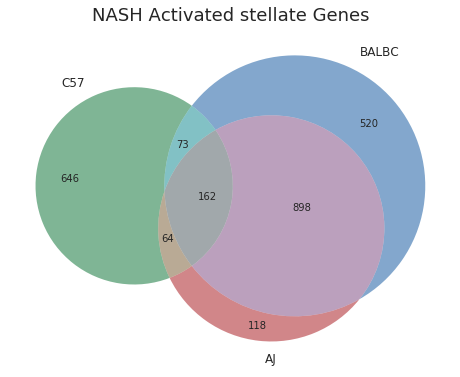

In [14]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(gene_list_dict['c57_stellate_amlndiet_30weeks_up']),
               set(gene_list_dict['balbc_stellate_amlndiet_30weeks_up']),
               set(gene_list_dict['aj_stellate_amlndiet_30weeks_up'])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Activated stellate Genes');

plt.savefig('./figures/venn3_activated_genes.png', bbox_inches='tight')

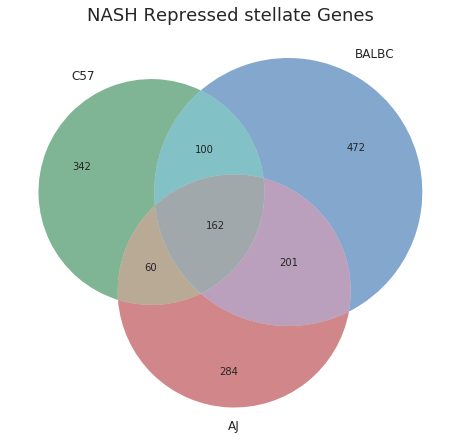

In [15]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(gene_list_dict['c57_stellate_control_young_up']),
               set(gene_list_dict['balbc_stellate_control_young_up']),
               set(gene_list_dict['aj_stellate_control_young_up'])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Repressed stellate Genes');

plt.savefig('./figures/venn3_repressed_genes.png', bbox_inches='tight')

### Pull sets for manual examination

activated genes

In [16]:
all3 = set(gene_list_dict['aj_stellate_amlndiet_30weeks_up']).intersection(set(gene_list_dict['balbc_stellate_amlndiet_30weeks_up']).intersection(gene_list_dict['c57_stellate_amlndiet_30weeks_up']))
C57_balbc = set(gene_list_dict['c57_stellate_amlndiet_30weeks_up']).intersection(set(gene_list_dict['balbc_stellate_amlndiet_30weeks_up']).difference(all3))
C57_aj = set(gene_list_dict['c57_stellate_amlndiet_30weeks_up']).intersection(set(gene_list_dict['aj_stellate_amlndiet_30weeks_up']).difference(all3))
balbc_aj = set(gene_list_dict['balbc_stellate_amlndiet_30weeks_up']).intersection(gene_list_dict['aj_stellate_amlndiet_30weeks_up']).difference(all3)
C57_private = set(gene_list_dict['c57_stellate_amlndiet_30weeks_up']).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
balbc_private = set(gene_list_dict['balbc_stellate_amlndiet_30weeks_up']).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
aj_private = set(gene_list_dict['aj_stellate_amlndiet_30weeks_up']).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

In [17]:
genesets = [aj_private, balbc_private, C57_private]
genesetnames = ['aj_private', 'balbc_private', 'c57_private']
for listname, genelist in zip(genesetnames, genesets):
    with open('./gene_lists/'+listname+'_stellate_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in genelist:
            f.write(i+'\n')
        f.close()

# Plot potential nichenet ligands

In [18]:
tpm_mat = pd.read_csv('./expression/rawT.txt', sep='\t', index_col=0)

In [19]:
ligands = pd.read_csv('/home/h1bennet/data/gene_lists/nichenet_ligands.txt',
                      sep='\t')['x'].str.capitalize().tolist()
ligands[:5]

['Cxcl1', 'Cxcl2', 'Cxcl3', 'Cxcl5', 'Ppbp']

Collect ALL activated NASH genes

In [20]:
amln_act = []
for key in gene_list_dict.keys():
    if 'amln' in key:
        amln_act.extend(gene_list_dict[key])

amln_act = set(amln_act)

Assess for overlap with ligands

In [21]:
amln_act_ligands = amln_act.intersection(ligands)

## Plot for all samples

In [22]:
tpm_mat.columns

Index(['c57_stellate_control_young_c57_stellate_control_young_C5701A',
       'c57_stellate_control_young_c57_stellate_control_young_C5701B',
       'c57_stellate_control_young_c57_stellate_control_young_C5701C',
       'c57_stellate_amlndiet_30weeks_c57_stellate_amlndiet_30weeks_LN136C',
       'c57_stellate_amlndiet_30weeks_c57_stellate_amlndiet_30weeks_LN141A',
       'balbc_stellate_control_young_c57_stellate_control_young_BALB01A',
       'balbc_stellate_control_young_c57_stellate_control_young_BALB01B',
       'balbc_stellate_control_young_c57_stellate_control_young_BALB01C',
       'balbc_stellate_control_young_c57_stellate_control_young_BALB01D',
       'balbc_stellate_amlndiet_30weeks_c57_stellate_amlndiet_30weeks_Balb3a',
       'balbc_stellate_amlndiet_30weeks_c57_stellate_amlndiet_30weeks_Balb3d',
       'aj_stellate_control_young_c57_stellate_control_young_AJ01A',
       'aj_stellate_control_young_c57_stellate_control_young_AJ01B',
       'aj_stellate_control_young_c57_ste

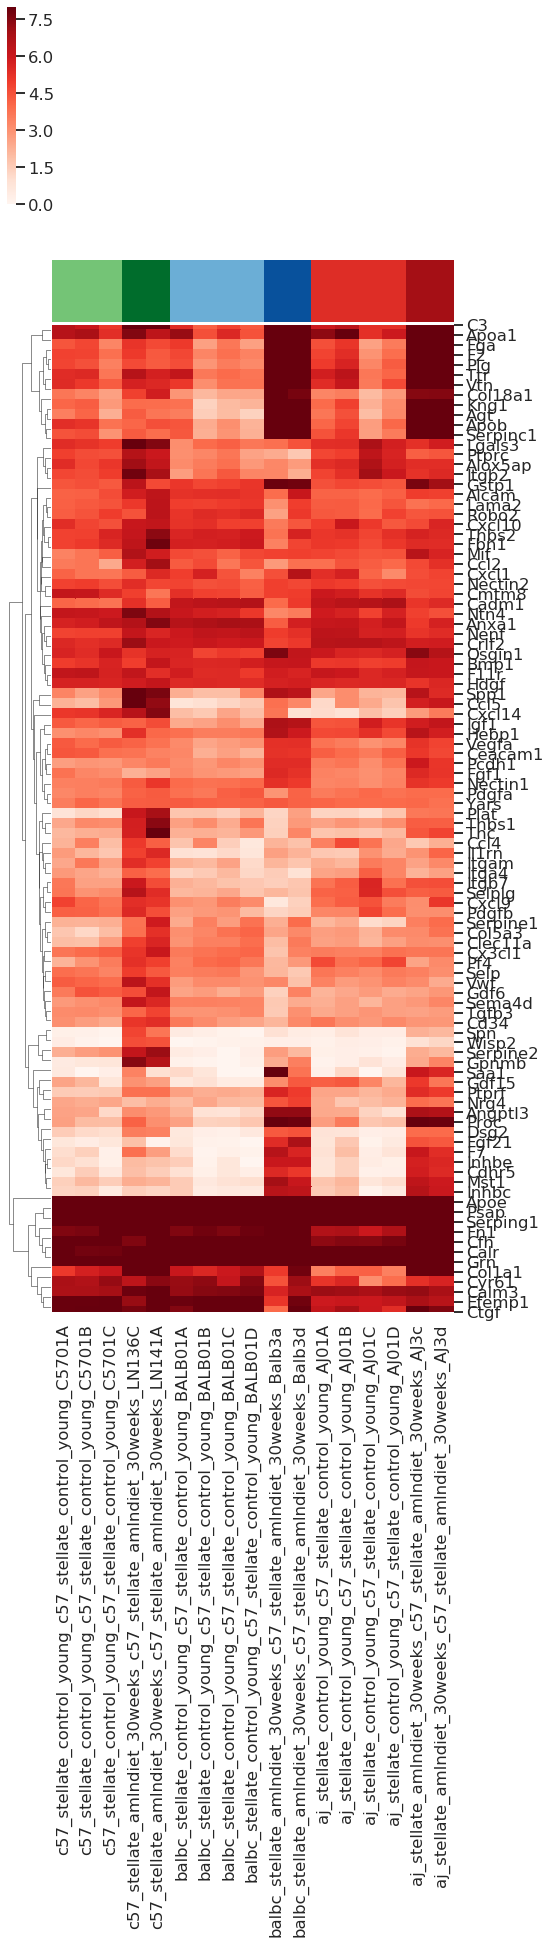

In [24]:
sns.clustermap(
    np.log2(tpm_mat.loc[amln_act_ligands]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    col_colors = ['#74c476', '#74c476', '#74c476',
          '#006d2c', '#006d2c',
          '#6baed6', '#6baed6', '#6baed6', '#6baed6',
          '#08519c', '#08519c',
          '#de2d26', '#de2d26', '#de2d26', '#de2d26',
          '#a50f15', '#a50f15'],
    figsize=(8,24),
    yticklabels=1)

plt.savefig('./figures/diff_genes_ligands_clustermap.png', bbox_inches='tight')
# plt.close()

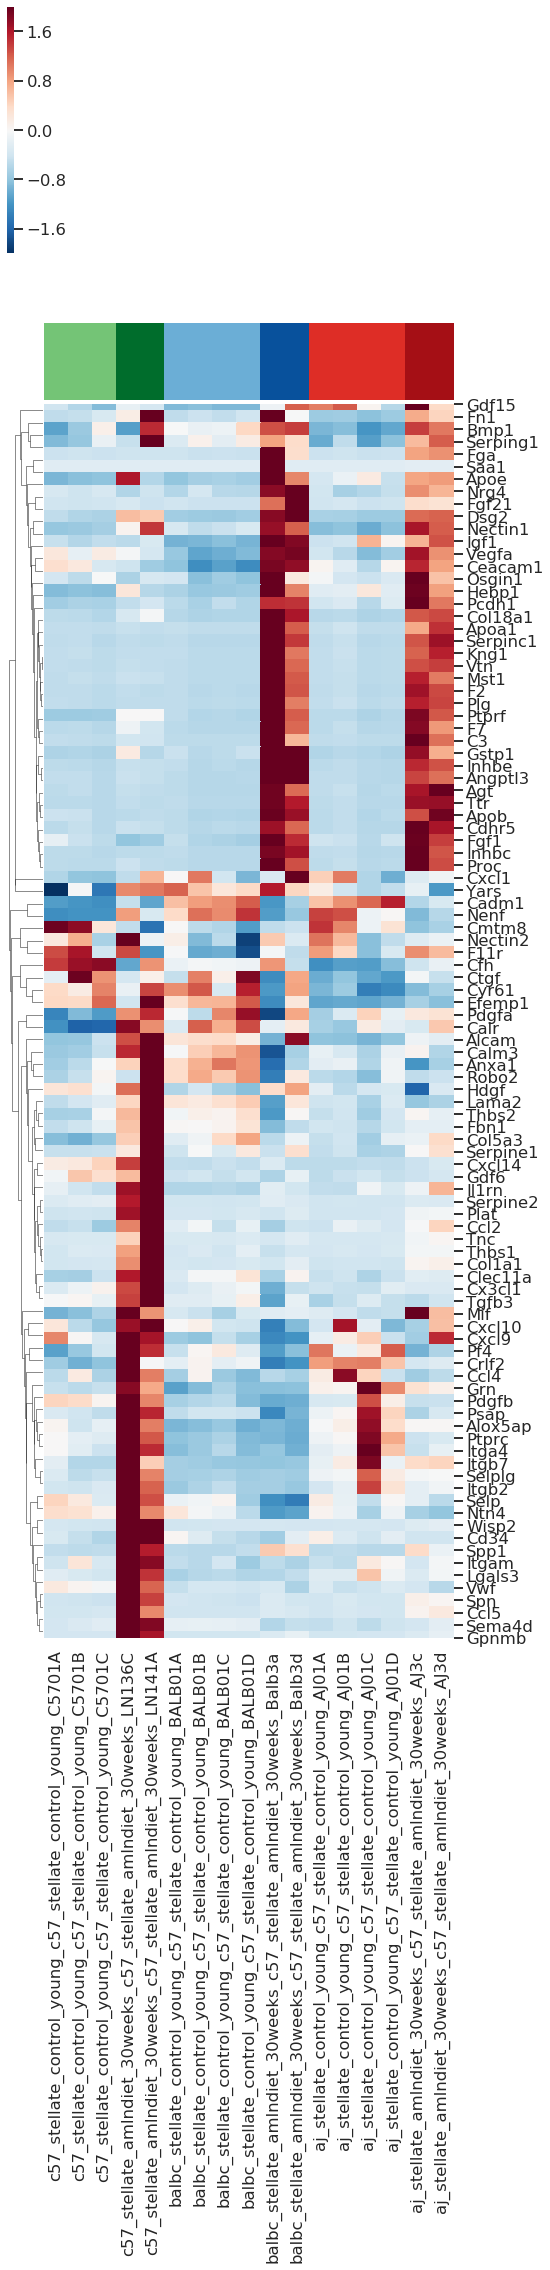

In [29]:
sns.clustermap(
    tpm_mat.loc[amln_act_ligands],
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-2,
    vmax=2,
    col_colors = ['#74c476', '#74c476', '#74c476',
          '#006d2c', '#006d2c',
          '#6baed6', '#6baed6', '#6baed6', '#6baed6',
          '#08519c', '#08519c',
          '#de2d26', '#de2d26', '#de2d26', '#de2d26',
          '#a50f15', '#a50f15'],
    figsize=(8,30),
    yticklabels=1)

plt.savefig('./figures/diff_genes_ligands_clustermap_zscore.png', bbox_inches='tight')
# plt.close()

## Plot Strain Specific Ligands

In [26]:
all_strain_spec = C57_private.union(aj_private).union(balbc_private)
all_strain_spec_ligands = all_strain_spec.intersection(ligands)

In [35]:
aj_private.intersection(ligands)

{'Ctgf', 'Cyr61', 'Efemp1', 'Gdf15'}

In [36]:
balbc_private.intersection(ligands)

{'Cmtm8', 'F11r', 'Hdgf', 'Nectin2', 'Yars'}

In [37]:
C57_private.intersection(ligands)

{'Alox5ap',
 'Anxa1',
 'Cadm1',
 'Calm3',
 'Calr',
 'Ccl4',
 'Cd34',
 'Clec11a',
 'Col5a3',
 'Crlf2',
 'Cx3cl1',
 'Cxcl10',
 'Cxcl14',
 'Cxcl9',
 'Gdf6',
 'Gpnmb',
 'Grn',
 'Il1rn',
 'Itga4',
 'Itgam',
 'Itgb2',
 'Itgb7',
 'Lama2',
 'Nenf',
 'Ntn4',
 'Pdgfa',
 'Pdgfb',
 'Pf4',
 'Plat',
 'Psap',
 'Ptprc',
 'Robo2',
 'Selp',
 'Selplg',
 'Sema4d',
 'Serpine1',
 'Serpine2',
 'Spn',
 'Tgfb3',
 'Vwf',
 'Wisp2'}

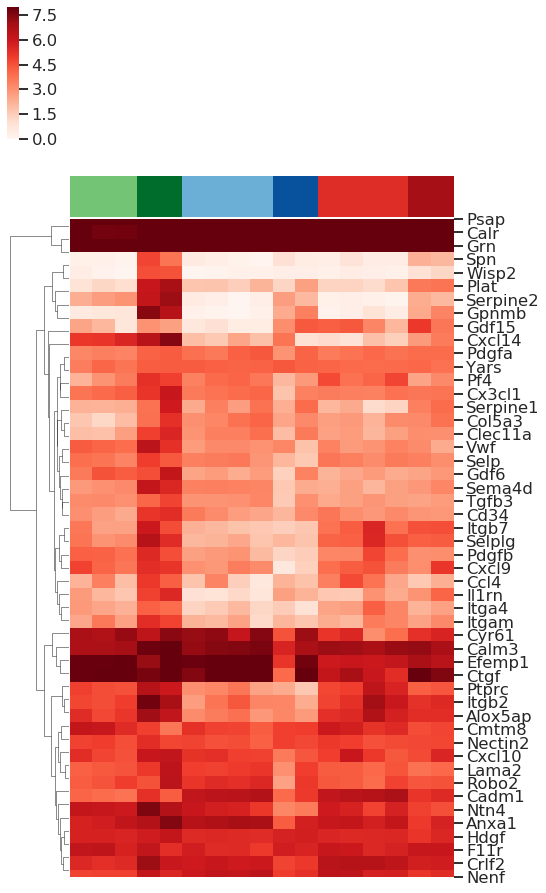

In [33]:
sns.clustermap(
    np.log2(tpm_mat.loc[all_strain_spec_ligands]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    col_colors = ['#74c476', '#74c476', '#74c476',
          '#006d2c', '#006d2c',
          '#6baed6', '#6baed6', '#6baed6', '#6baed6',
          '#08519c', '#08519c',
          '#de2d26', '#de2d26', '#de2d26', '#de2d26',
          '#a50f15', '#a50f15'],
    figsize=(8,16),
    yticklabels=1,
    xticklabels=0)

plt.savefig('./figures/diff_genes_strainspecligands_clustermap.png',
            bbox_inches='tight')
# plt.close()

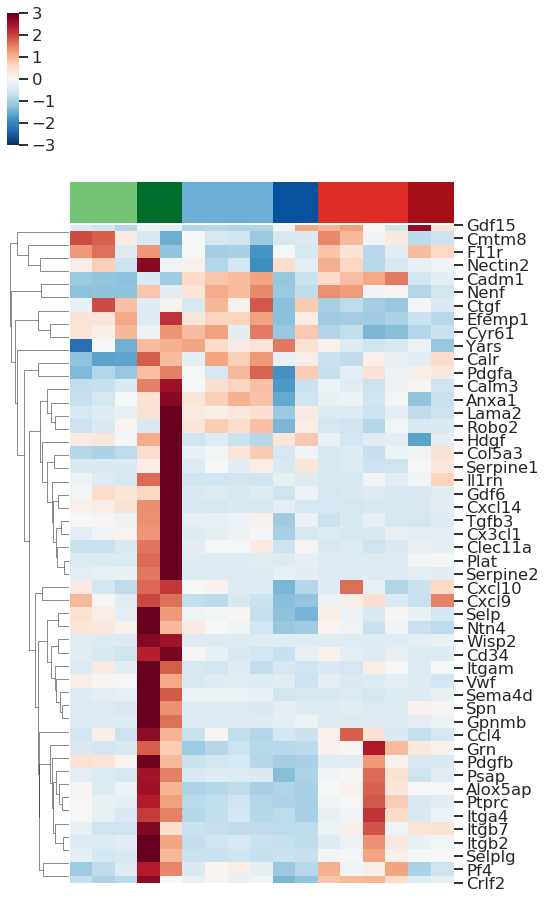

In [32]:
sns.clustermap(
    tpm_mat.loc[all_strain_spec_ligands],
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-3,
    vmax=3,
    col_colors = ['#74c476', '#74c476', '#74c476',
          '#006d2c', '#006d2c',
          '#6baed6', '#6baed6', '#6baed6', '#6baed6',
          '#08519c', '#08519c',
          '#de2d26', '#de2d26', '#de2d26', '#de2d26',
          '#a50f15', '#a50f15'],
    figsize=(8,16),
    yticklabels=1,
    xticklabels=0)

plt.savefig('./figures/diff_genes_strainspecligands_clustermap_zscore.png',
            bbox_inches='tight')
# plt.close()

# Plot specific genes as barplots

In [36]:
groups = [[0,1,2,3],
          [4,5],
          [6,7,8,9],
          [10,11],
          [12,13,14,15],
          [16,17]]

group_labels = ['C57BL/6J stellate Control young',
                'C57BL/6J stellate AMLN 30 weeks',
                'Balb/cJ stellate Control young',
                'Balb/cJ stellate AMLN 30 weeks',
                'AJ stellate Control young',
                'AJ stellate AMLN 30 weeks',]

colors = ['#74c476',
          '#006d2c',
          '#6baed6',
          '#08519c',
          '#de2d26',
          '#a50f15']

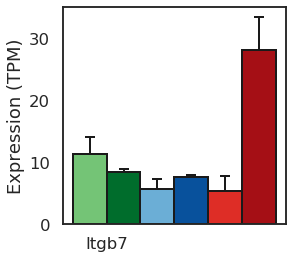

In [85]:
fig, ax = plt.subplots(figsize=(4, 4))

gene_list_bar_plot(['Itgb7'],
                   tpm_mat,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   ax=ax)

ax.get_legend().remove()